# Import Important Packages

In [1]:
import os
import shutil
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from skimage import color, io,transform,feature,exposure,img_as_ubyte,filters,measure
from sklearn.feature_extraction.image import PatchExtractor
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import KFold
from sklearn.metrics import silhouette_score


# Image Feature Extraction Functions (lpb, Gabor, Blur, Histogram, Hog)

In [2]:
# Function to extract HOG features from an image and visualize it
def extract_lbp_features(image):
    
    # Resize the image to a consistent size
    # resized_image = transform.resize(image, (64, 64))     
    
    # Convert the image to grayscale
    gray_image = color.rgb2gray(image)
    imgubyte = img_as_ubyte(gray_image)

    # Compute LBP
    radius = 3
    n_points = 8 * radius
    lbp = feature.local_binary_pattern(imgubyte, n_points, radius, method='uniform')
    
    # Compute histogram of LBP
    hist, _ = np.histogram(lbp.ravel(), bins=np.arange(0, n_points + 3), range=(0, n_points + 2)) #, density=True
    hist = hist.astype("float")
    hist /= (hist.sum() + 1e-7)

    return hist


# Function to extract Gabor features from an image
def extract_gabor_features(image, frequency=0.6, theta=0.0):
    
    # Convert the image to grayscale
    gray_image = color.rgb2gray(image)
    
    # Convert the image to its integral image representation
    integral_image = transform.integral_image(gray_image)
    
    # Create a Gabor filter kernel
    gabor_kernel = filters.gabor(integral_image, frequency=frequency, theta=theta)[0]
    
    # Compute Gabor filter response using the integral image
    gabor_response = np.abs(gabor_kernel)
    
    return np.mean(gabor_response)


# Function to extract blur features from an image
def extract_blur_feature(image):
    gray_image = color.rgb2gray(image)
    blur_level = filters.gaussian(image, sigma=2)  # You can experiment with different sigma values
    return np.mean(blur_level)


# Function to extract histogram features from an image
def extract_histogram_features(image, bins=8):
    hsv_image = color.rgb2hsv(image)
    hist_hue = exposure.histogram(hsv_image[:, :, 0], nbins=bins)[0]
    hist_saturation = exposure.histogram(hsv_image[:, :, 1], nbins=bins)[0]
    hist_value = exposure.histogram(hsv_image[:, :, 2], nbinsimage_data_pcaimage_data_pca=bins)[0]
    hist_combined = np.concatenate((hist_hue, hist_saturation,hist_value ))
    hist_combined = hist_combined.astype("float")
    hist_combined /= (hist_combined.sum() + 1e-7)
    return hist_combined


# extract hog with grayscale
def extract_features(image):
    # Convert the image to grayscale
    gray_image = color.rgb2gray(image)

    # Extract HOG features
    features, _ = feature.hog(gray_image, visualize=True)
    
    features = np.array(features).astype("float")

    return features


# Function to extract combined features
def extract_combined_features(image):
    histogram_features = extract_histogram_features(image)
    lbp_features = extract_lbp_features(image)
    # gabor_features = extract_gabor_features(image)
    lbp_features = lbp_features.reshape(1, -1)  # Ensure LBP features are flattened
    histogram_features = histogram_features.reshape(1, -1)
    # gabor_features = gabor_features.reshape(1, -1)  # Ensure histogram features are flattened
    return np.concatenate((histogram_features,lbp_features ), axis=1)


# Function Fusion

def extract_fusioned_features(image):
    histogram_features = extract_histogram_features(image)
    lbp_features = extract_lbp_features(histogram_features)
    lbp_features = lbp_features.reshape(1, -1)  # Ensure LBP features are flattened
    return np.concatenate((lbp_features,histogram_features ), axis=1)


# Function to extract histogram features from an image
def extract_histogram_features(image, bins=5):
    hsv_image = color.rgb2hsv(image)
    hist_hue = exposure.histogram(hsv_image[:, :, 0], nbins=bins)[0]
    hist_saturation = exposure.histogram(hsv_image[:, :, 1], nbins=bins)[0]
    hist_value = exposure.histogram(hsv_image[:, :, 2], nbins=bins)[0]
    hist_combined = np.concatenate((hist_hue, hist_saturation,hist_value ))
    hist_combined = hist_combined.astype("float")
    hist_combined /= (hist_combined.sum() + 1e-7)
    return hist_combined



# List all subdirectories (Apply Feature Extraction on Each Image)

In [3]:
dataset_path = "leafs"

# List all subdirectories (assuming each subdirectory corresponds to a class)
class_folders = [f.path for f in os.scandir(dataset_path) if f.is_dir()]
features = []
img_name = []
 
# Loop through each class folder
for class_folder in class_folders:
    class_name = os.path.basename(class_folder)

    # Loop through each image in the class folder
    for inx, image_filename in enumerate(os.listdir(class_folder)):
        # if inx == 10 : break

        image_path = os.path.join(class_folder, image_filename) 
        # Load the image
        image = io.imread(image_path)
        hog_features = extract_histogram_features(image, bins=5)

        features.append(hog_features)
        if inx ==  1 : print(hog_features.shape)
        img_name.append(image_path)


(15,)
(15,)
(15,)


# Shuffle Features

In [4]:
# Combine pathes and images into pairs
combined_data = list(zip(features, img_name))

# Shuffle the combined data
random.shuffle(combined_data)

# Unpack the shuffled data and labels
features, img_name = zip(*combined_data)

# Convert the list of Features to a 2D array and Starndarize it

In [5]:
# Convert the list of images to a 2D array (assuming images have the same size) 
image_data = np.array((features)).reshape(len(features), -1)   

# Standardize the image data
scaler = StandardScaler()
image_data_standardized = scaler.fit_transform(image_data)

# Features Shape

In [15]:
print(image_data.shape)

(2997, 15)


# Apply PCA

In [6]:
# Apply PCA
num_components = 10  # Adjust the number of components based on your requirements
pca = PCA(n_components=num_components)
image_data_pca = pca.fit_transform(image_data_standardized)

# Visualize Variance

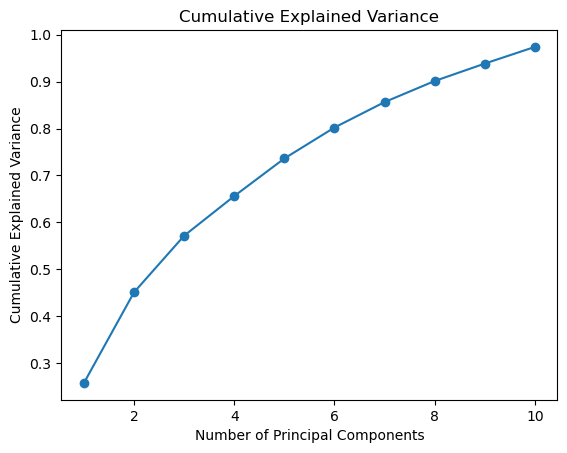

In [7]:
# Visualize the explained variance ratio
explained_variance_ratio = pca.explained_variance_ratio_
cumulative_explained_variance = np.cumsum(explained_variance_ratio)

plt.plot(range(1, num_components + 1), cumulative_explained_variance, marker='o')
plt.title('Cumulative Explained Variance')
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Explained Variance')
plt.show()

# Assign Features data to PCA data

In [8]:
features_data = image_data_pca

# K_folds & Number of Clusters

In [9]:
# Specify the number of clusters (adjust this based on your analysis)
num_clusters = 3

# Perform k-fold cross-validation
k_folds = 5
kf = KFold(n_splits=k_folds, shuffle=True, random_state=42)

# Fit Kmeans

In [10]:
# Initialize the KMeans model
kmeans_model = KMeans(n_clusters=num_clusters, random_state=42)

# Fit the model to your feature data
kmeans_model.fit(features_data)

image_cluster = pd.DataFrame(img_name,columns=['image'])
image_cluster["clusterid"] = kmeans_model.labels_

print(image_cluster)

                                                  image  clusterid
0     leafs/Pepper__bell___Bacterial_spot/799cf6ba-6...          1
1     leafs/Potato___Late_blight/a24f3bec-3fbb-461a-...          2
2     leafs/Potato___Early_blight/c9296b35-7b8b-4ac2...          0
3     leafs/Potato___Late_blight/5d392db5-bf54-41f4-...          2
4     leafs/Pepper__bell___Bacterial_spot/e8e03ae2-a...          2
...                                                 ...        ...
2992  leafs/Potato___Early_blight/17a06d03-8a7b-48a8...          1
2993  leafs/Pepper__bell___Bacterial_spot/e3f81cee-1...          2
2994  leafs/Potato___Early_blight/3aea17a1-9413-4312...          1
2995  leafs/Potato___Early_blight/096a2c48-104c-4570...          1
2996  leafs/Pepper__bell___Bacterial_spot/36aa1467-1...          1

[2997 rows x 2 columns]


/home/nash2t/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


# plotting the elbow graph

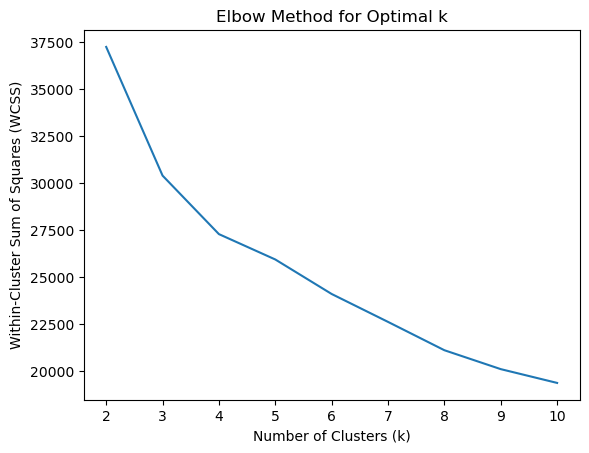

In [11]:
# For plotting the elbow graph
wcss = []

for k in range(2, 11):  # Try different values of k
    kmeans = KMeans(n_clusters=k, random_state=42, n_init='auto')
    kmeans.fit(image_data_pca)
    wcss.append(kmeans.inertia_)

plt.plot(range(2, 11), wcss)
plt.title('Elbow Method for Optimal k')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Within-Cluster Sum of Squares (WCSS)')
plt.show()

# plot first five images from each cluster

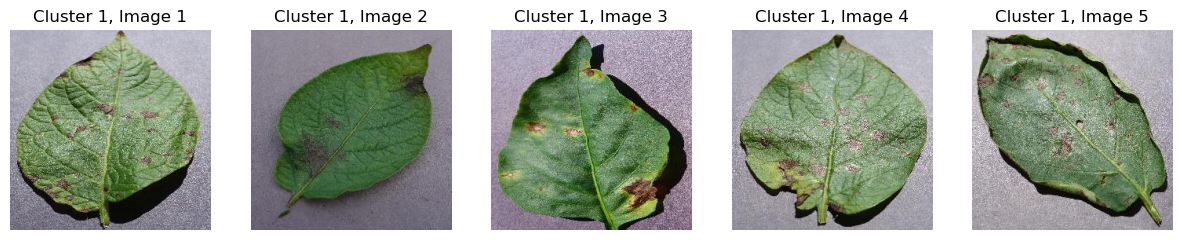

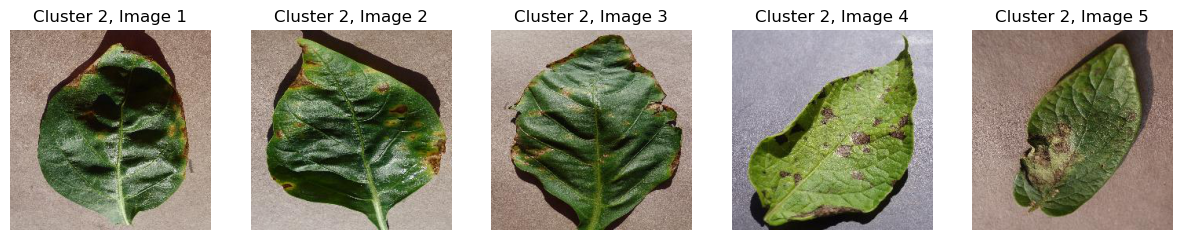

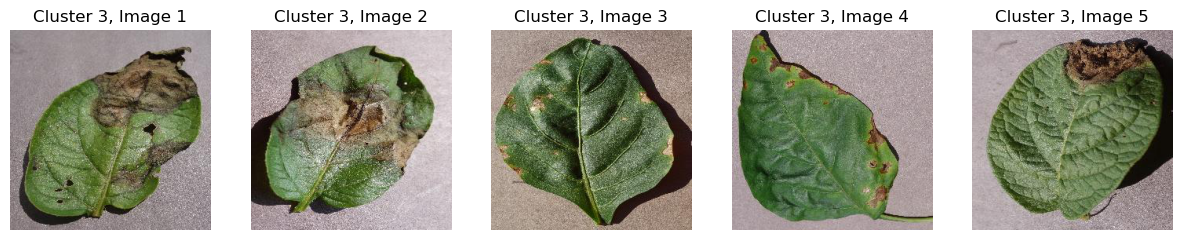

In [12]:
# Assuming you have a function to load images based on their file paths or data
def load_image(image_path):
    return io.imread(image_path)

# Iterate through each cluster
for cluster_id in range(num_clusters):
    # Select the first five images in the cluster
    cluster_images = image_cluster[image_cluster['clusterid'] == cluster_id]['image'][:5]

    # Plot the first five images in the cluster
    plt.figure(figsize=(15, 3))
    for i, image_path in enumerate(cluster_images):
        plt.subplot(1, 5, i + 1)
        image = load_image(image_path)
        plt.imshow(image)
        plt.axis('off')
        plt.title(f'Cluster {cluster_id + 1}, Image {i + 1}')

    plt.show()


# Export the Clusters

In [13]:
# # Images will be seperated according to cluster they belong

# for i in range(num_clusters): 
#     os.mkdir(str(i))

# for i in range(len(image_cluster)):
#     shutil.copy(image_cluster['image'][i], str(image_cluster['clusterid'][i]))


# Calculate Average Silhouette Score & plot Clusters with Centroid

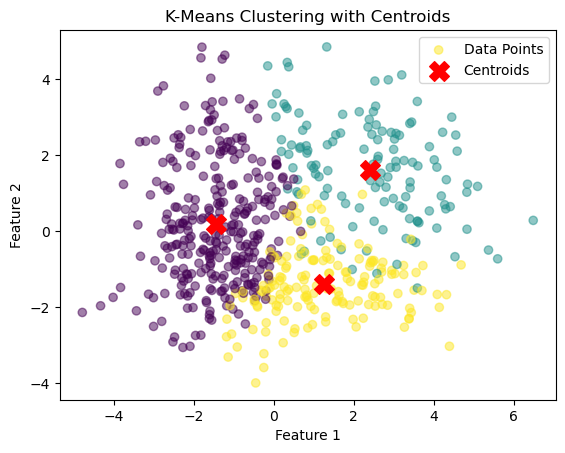

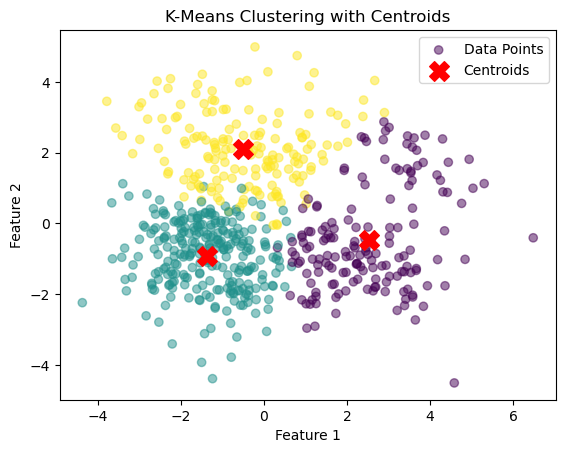

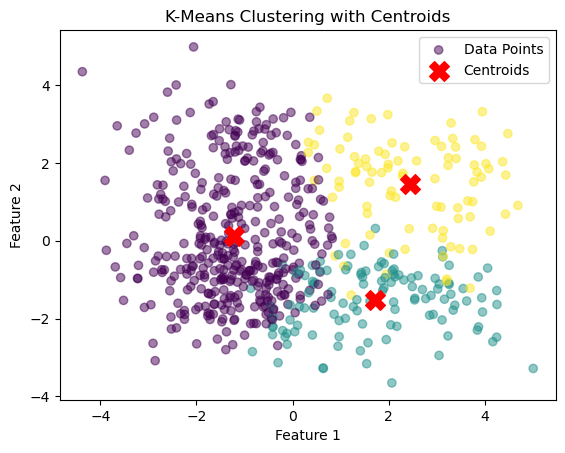

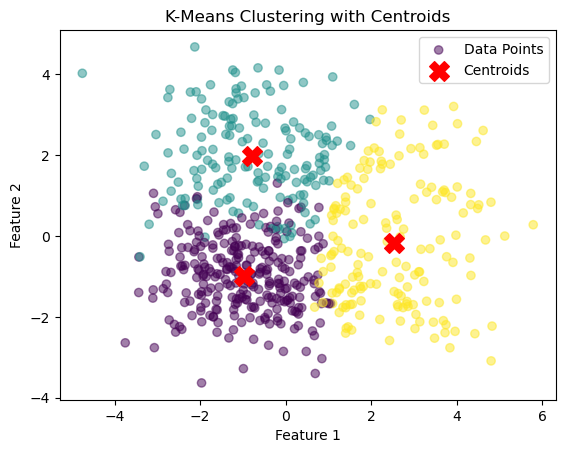

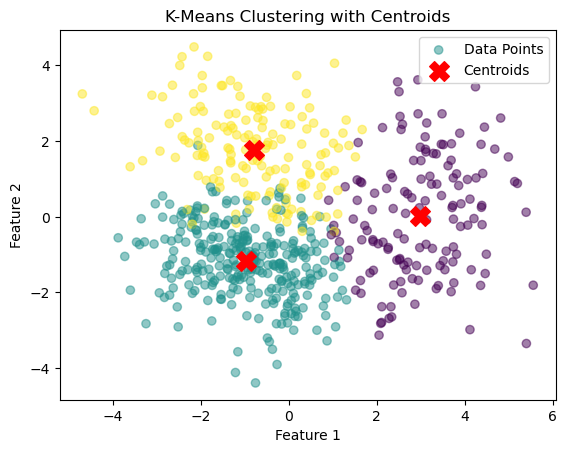

Average Silhouette Score across 5 folds: 0.20443898127015045


In [14]:
silhouette_scores = []

for train_index, test_index in kf.split(features_data):
    X_train, X_test = features_data[train_index], features_data[test_index]

    # You may need to choose an appropriate number of clusters (n_clusters) for your specific case
    kmeans = KMeans(n_clusters=3, random_state=42,n_init='auto')
    cluster_labels = kmeans.fit_predict(X_test)
    
    # Plotting the data points
    plt.scatter(X_test[:, 0], X_test[:, 1], c=cluster_labels, cmap='viridis', alpha=0.5, label='Data Points')

    # Plotting the centroids
    plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], c='red', marker='X', s=200, label='Centroids')

    plt.title('K-Means Clustering with Centroids')
    plt.xlabel('Feature 1')
    plt.ylabel('Feature 2')
    plt.legend()
    plt.show()

    # Step 5: Compute silhouette score for the current fold
    silhouette_avg = silhouette_score(X_test, cluster_labels)
    silhouette_scores.append(silhouette_avg)

# Step 6: Average silhouette scores over all folds
average_silhouette_score = np.mean(silhouette_scores)

print(f"Average Silhouette Score across {k_folds} folds: {average_silhouette_score}")




    